In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler

import numpy as np

## Problem 1



In [18]:
X = load_breast_cancer().data
y = load_breast_cancer().target

In [31]:
np.any(np.isnan(X))

False

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

In [36]:
scaler = MinMaxScaler().fit(X_train)

> a) use a regression model to classify (logistic regression) and record the accuracy.

In [37]:
logit = LogisticRegression(max_iter=999999).fit(scaler.transform(X_train), y_train)
preds = logit.predict(scaler.transform(X_test))

print(accuracy_score(y_test, preds))

0.9736842105263158


> b) use AdaBoost with 7 logistic regression base learner experts and compare results.

In [38]:
adaboost = AdaBoostClassifier(
                base_estimator=LogisticRegression(max_iter=999999),
                n_estimators=7).fit(scaler.transform(X_train), y_train)
preds = adaboost.predict(scaler.transform(X_test))

print(accuracy_score(y_test, preds))

0.868421052631579


> c) compare with other numbers of experts (ex. 3, 10)

In [39]:
n_estimators = range(2, 30, 2)
for n in n_estimators:
    adaboost = AdaBoostClassifier(
                base_estimator=LogisticRegression(max_iter=999999),
                n_estimators=n).fit(scaler.transform(X_train), y_train)
    preds = adaboost.predict(scaler.transform(X_test))

    print(f"Accuracy with {n} estimatros = {accuracy_score(y_test, preds)}")

Accuracy with 2 estimatros = 0.6666666666666666
Accuracy with 4 estimatros = 0.7894736842105263
Accuracy with 6 estimatros = 0.8596491228070176
Accuracy with 8 estimatros = 0.9035087719298246
Accuracy with 10 estimatros = 0.9122807017543859
Accuracy with 12 estimatros = 0.9298245614035088
Accuracy with 14 estimatros = 0.9385964912280702
Accuracy with 16 estimatros = 0.9385964912280702
Accuracy with 18 estimatros = 0.956140350877193
Accuracy with 20 estimatros = 0.9736842105263158
Accuracy with 22 estimatros = 0.9736842105263158
Accuracy with 24 estimatros = 0.9736842105263158
Accuracy with 26 estimatros = 0.9736842105263158
Accuracy with 28 estimatros = 0.9736842105263158


> repeat a, b and c with decision tree base learner experts. Suggestion: try to use different
number of experts, e.g. 15, 17, 20, 23, and so on.

In [40]:
dtc = DecisionTreeClassifier().fit(scaler.transform(X_train), y_train)
preds = dtc.predict(scaler.transform(X_test))

print(accuracy_score(y_test, preds))

0.9210526315789473


In [41]:
adaboost = AdaBoostClassifier(
                base_estimator=DecisionTreeClassifier(),
                n_estimators=7).fit(scaler.transform(X_train), y_train)
preds = adaboost.predict(scaler.transform(X_test))

print(accuracy_score(y_test, preds))

0.9298245614035088


In [42]:
n_estimators = range(2, 30, 2)
for n in n_estimators:
    adaboost = AdaBoostClassifier(
                base_estimator=DecisionTreeClassifier(),
                n_estimators=n).fit(scaler.transform(X_train), y_train)
    preds = adaboost.predict(scaler.transform(X_test))

    print(f"Accuracy with {n} estimatros = {accuracy_score(y_test, preds)}")

Accuracy with 2 estimatros = 0.9385964912280702
Accuracy with 4 estimatros = 0.9385964912280702
Accuracy with 6 estimatros = 0.9385964912280702
Accuracy with 8 estimatros = 0.9385964912280702
Accuracy with 10 estimatros = 0.9385964912280702
Accuracy with 12 estimatros = 0.9385964912280702
Accuracy with 14 estimatros = 0.9385964912280702
Accuracy with 16 estimatros = 0.9298245614035088
Accuracy with 18 estimatros = 0.9385964912280702
Accuracy with 20 estimatros = 0.9298245614035088
Accuracy with 22 estimatros = 0.9298245614035088
Accuracy with 24 estimatros = 0.9385964912280702
Accuracy with 26 estimatros = 0.9298245614035088
Accuracy with 28 estimatros = 0.9385964912280702


## Problem 2

In [115]:
import numpy as np

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [98]:
X = load_breast_cancer().data
y = load_breast_cancer().target

In [99]:
X.shape

(569, 30)

In [133]:
X, X_unseen, y, y_unseen = train_test_split(X, y, test_size=0.1, random_state=0)

In [134]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

In [135]:
scaler = MinMaxScaler().fit(X)

In [136]:
X_scaled = scaler.transform(X)

In [137]:
class EnsembleAverage:
    def __init__(self, 
                experts: list,
                scaler=MinMaxScaler()
    ):
        self.n_models = len(experts)
        self.experts = experts
        self.weights = np.zeros(self.n_models)
        self.scaler=scaler
    
    def fit(self, X, y, shuffle=False) -> EnsembleAverage:
        for i in range(self.n_models):
            score = self.cv_score(
                self.experts[i], 
                X, 
                y, 
                cv=5,
                shuffle=shuffle
            ).mean()
            self.weights[i] = score
            model = self.experts[i].fit(
                self.scaler.fit_transform(X),
                y
            )
        self.scaler.fit(X)
        return self
        
        
    def predict(self, X) -> list:
        X_scaled = self.scaler.transform(X)
        preds = np.array([ model.predict(X_scaled) for model in self.experts])
        pred = np.round( self.get_gate() @ preds )
        return pred
    
    
    def get_params(self, deep) -> dict:
        return {
            "experts" : self.experts,
            "scaler": self.scaler
        }
    
    
    def __softmax(self, W):
        return np.exp(W) / np.exp(W).sum()
    
    
    def get_gate(self):
        return self.__softmax(self.weights)
    
    
    def cv_score(self, model, X, y, cv=5, shuffle=False):
        N = np.ceil(X.shape[0] / cv).astype(int)
        
        if shuffle:
            idx_shuffled = list(range(X.shape[0]))
            np.random.shuffle(idx_shuffled)
            X = X[idx_shuffled]
            y = y[idx_shuffled]
        
        cv_results = []
        for i in range(cv):            
            train_idx_left = slice( max(0, (i-1) )*N, i*N )
            train_idx_rigth = slice( (i+1)*N, None )
            test_idx = slice(i*N, (i+1)*N)
            
            
            x_train_left, y_train_left = X[ train_idx_left], y[train_idx_left ]
            x_train_rigth, y_train_rigth = X[ train_idx_rigth ], y[train_idx_rigth ]
            
            x_train = np.concatenate((x_train_left, x_train_rigth))
            y_train = np.concatenate((y_train_left, y_train_rigth))
            x_test, y_test = X[ test_idx ], y[test_idx]
            
            self.scaler.fit(x_train)
            x_train_scaled = self.scaler.transform(x_train)
            x_test_scaled = self.scaler.transform(x_test)
            
            model.fit(x_train_scaled, y_train)
            cv_results.append( 
                accuracy_score( 
                    y_test, 
                    model.predict(x_test_scaled) 
                ) 
            )
            
        return np.array(cv_results)
            
                 

In [138]:
model = EnsembleAverage(
    experts=[
        #DecisionTreeClassifier(criterion="entropy"),
        DecisionTreeClassifier(),
        SVC(),
        #SVC(kernel="poly"),
        GaussianNB(),
        LogisticRegression(max_iter=999999)
    ],
    scaler=StandardScaler()
)

In [139]:
model.fit(X, y, True)

In [140]:
model.weights

array([0.91956522, 0.9673913 , 0.94347826, 0.97391304])

0.9807692307692307
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        19
           1       0.97      1.00      0.99        33

    accuracy                           0.98        52
   macro avg       0.99      0.97      0.98        52
weighted avg       0.98      0.98      0.98        52



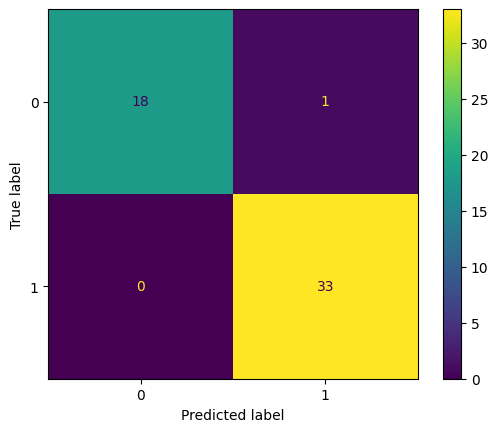

In [141]:
preds = model.predict(X_unseen)
print(accuracy_score(y_unseen, preds))

print(classification_report(y_unseen, preds))

ConfusionMatrixDisplay(
    confusion_matrix(y_unseen, preds)
).plot()